<a href="https://www.kaggle.com/code/zhengyangio/redsp-market-analytics?scriptVersionId=135001825" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import squarify
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 汉字字体，优先使用楷体，找不到则使用黑体
plt.rcParams['font.sans-serif'] = ['Kaitt', 'SimHei']
 
# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

# # 清空output
# import shutil
 
# if __name__ == '__main__':
#     path = '/kaggle/working'
#     if os.path.exists(path):
#         shutil.rmtree(path)
#         print('删除完成')
#     else:
#         print('原本为空')

/kaggle/input/sellerdatatest/cleaned_data.csv
/kaggle/input/sellerdatatest/Search(table-runner)-339-US-20230627.csv
/kaggle/input/sellerdatatest/TableRunnerMultiTimeline.csv


# 参数设置

In [2]:
# 参数设置
原始数据路径 = '/kaggle/input/sellerdatatest/Search(table-runner)-339-US-20230627.csv'
google数据路径 = '/kaggle/input/sellerdatatest/TableRunnerMultiTimeline.csv'
特征原始数据路径 = '/kaggle/input/sellerdatatest/cleaned_data.csv'

## 1. 数据清洗 Data clean

In [3]:
# read csv
df_rawdata = pd.read_csv(原始数据路径)
minimum_days = 150

# add new columns
df_rawdata['COLOR'] = ''
df_rawdata['SIZE'] = ''
df_rawdata['W'] = ''
df_rawdata['D'] = ''
df_rawdata['H'] = ''
df_rawdata['STYLE'] = ''
df_rawdata['ACCESSORIES'] = ''
df_rawdata['NUMBER_OF_ITEMS'] = ''
df_rawdata['MATERIAL'] = ''
df_rawdata['SHAPE'] = ''
df_rawdata['SPECS'] = ''
df_rawdata['BULLETS'] = ''
df_rawdata['DESC'] = ''
df_rawdata['日销'] = ''

df_rawdata.columns

def check_null(val):
    return pd.isnull(val) or val == ''

# clean null data and convert to number
drop_indexes = []
number_cols = ['近30天销量', '近30天销售额($)', '价格($)', 'FBA($)', '评分数', 
               'Q&A数', '上架天数', '大类BSR', '小类BSR']
for key, row in df_rawdata.iterrows():
    if check_null(row['上架时间']) or check_null(row['近30天销量']):
        print(f'dropped {row["ASIN"]}.')
        drop_indexes.append(key)
        continue
    for col in number_cols:
        # turn str value to number value
        if type(row[col]) == str:
            val = row[col]
            # multi BSRs
            if col == '小类BSR' and '\n' in row['小类BSR']:
                val = val.split('\n')[0]
            df_rawdata.loc[key, col] = float(val.replace(',', '').strip())
            
    df_rawdata.loc[key, '日销'] = round(df_rawdata.loc[key, '近30天销量'] / 30)
df_rawdata.drop(drop_indexes, inplace = True )

# filter daily sales over 5
df_rawdata = df_rawdata[df_rawdata['近30天销量'] > minimum_days]
# switch the column order
df_rawdata.insert(1, '上架天数', df_rawdata.pop('上架天数'))
df_rawdata.insert(1, '配送方式', df_rawdata.pop('配送方式'))
df_rawdata.insert(1, 'FBA($)', df_rawdata.pop('FBA($)'))
df_rawdata.insert(1, '评分数', df_rawdata.pop('评分数'))
df_rawdata.insert(1, '评分', df_rawdata.pop('评分'))
df_rawdata.insert(1, 'Q&A数', df_rawdata.pop('Q&A数'))
df_rawdata.insert(1, '价格($)', df_rawdata.pop('价格($)'))
df_rawdata.insert(1, '近30天销售额($)', df_rawdata.pop('近30天销售额($)'))
df_rawdata.insert(1, '近30天销量', df_rawdata.pop('近30天销量'))
df_rawdata.insert(1, '品牌', df_rawdata.pop('品牌'))
df_rawdata.insert(1, '商品标题', df_rawdata.pop('商品标题'))
df_rawdata.insert(0, 'ASIN', df_rawdata.pop('ASIN'))

# 去重，去除PASIN相同的子体
df_rawdata.drop_duplicates(subset=['PASIN'], keep='first', inplace=True)

# sort
df_rawdata = df_rawdata.sort_values(by=['近30天销售额($)'], ascending=False)
print('||'.join(df_rawdata.columns))

# 特征解构
for key, row in df_rawdata.iterrows():
    size = row['体积']
    if check_null(size):
        print(f'None size data {key}')
        continue
    wdhs = size.replace('"L', '').replace('"H', '').replace('"W', '').replace('"D', '')\
    .replace(' inches', '').split(' x ')
    wdhs = [float(x) for x in wdhs]
    wdhs.sort(reverse=True)
#     df_rawdata.loc[key, 'W'] = wdhs[0]
#     df_rawdata.loc[key, 'D'] = wdhs[1]
#     df_rawdata.loc[key, 'H'] = wdhs[2]
    if len(wdhs) > 2:
        df_rawdata.loc[key, 'W'] = round(wdhs[0])
        df_rawdata.loc[key, 'D'] = round(wdhs[1])
        df_rawdata.loc[key, 'H'] = round(wdhs[2])
    elif len(wdhs) > 1:
        df_rawdata.loc[key, 'W'] = round(wdhs[0])
        df_rawdata.loc[key, 'D'] = round(wdhs[1])
    else:
        df_rawdata.loc[key, 'W'] = round(wdhs[0])
print("特征解构完成：尺寸")
print(df_rawdata[['W', 'D', 'H']].head(1))

# 空字符串处理
df_rawdata.replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
# 分成五个区间
def in_interval(val, interval):
    if type(val) == str:
        return False
    if val < interval[1] and val >= interval[0]:
        return True
    else:
        return False
whd_cols = ['W', 'D', 'H']
for col in whd_cols:
    # 平均值填充
    df_rawdata[col].fillna(df_rawdata[col].mean())
    # 找到最大值和最小值
    max_value = round(df_rawdata[col].max()+5, 2) # 多预留5个点
    min_value = round(df_rawdata[col].min(), 2)
    print(max_value, min_value)
    # 计算均匀数值区间
    interval = (max_value - min_value) / 5
    # 计算五个均匀数值区间的起始值和结束值
    intervals = [(min_value + i * interval, min_value + (i+1) * interval) for i in range(5)]
    print(f'区间{col}: {intervals}')
    for index, row in df_rawdata.iterrows():
        for interval in intervals:
            if in_interval(df_rawdata.loc[index, col], interval):
                left = round(interval[0], 2)
                right = round(interval[1], 2)
                df_rawdata.loc[index, col] = f'{left}-{right}'
df_rawdata_1yr = df_rawdata[df_rawdata['上架天数'] <= 366]
df_rawdata_180d = df_rawdata[df_rawdata['上架天数'] <= 180]
print(f'all {len(df_rawdata)}')
print(f'1yr {len(df_rawdata_1yr)}')
print(f'180d {len(df_rawdata_180d)}')

df_rawdata.to_csv('/kaggle/working/cleaned_data.csv', index=False)
df_rawdata_1yr.to_csv('/kaggle/working/cleaned_data_1yr.csv', index=False)
df_rawdata_180d.to_csv('/kaggle/working/cleaned_data_180d.csv', index=False)

dropped B096WX8YYC.
dropped B01NH5E8RF.
dropped B077MNNWMT.
dropped B08L4B74X4.
dropped B081DSNRFW.
dropped B0C2HLC4K4.
dropped B08ZLRGBQ1.
dropped B07T138PMQ.
dropped B0BZYKTH7R.
dropped B0BXKJ9YPZ.
dropped B07RM4HB1Q.
dropped B0BYN45L41.
dropped B0C591ZZ8F.
ASIN||图片||商品标题||品牌||近30天销量||近30天销售额($)||价格($)||Q&A数||评分||评分数||FBA($)||配送方式||上架天数||PASIN||SKU||URL||商品主图||品牌链接||亚马逊标识||类目路径||大类目||大类BSR||小类目||小类BSR||毛利率||留评率||月新增
评分数||评级||上架时间||变体数||卖家数||Buybox卖家||卖家所属地||卖家信息||重量||体积||COLOR||SIZE||W||D||H||STYLE||ACCESSORIES||NUMBER_OF_ITEMS||MATERIAL||SHAPE||SPECS||BULLETS||DESC||日销
特征解构完成：尺寸
      W   D H
27  102  60  
221 8
区间W: [(8.0, 50.6), (50.6, 93.2), (93.2, 135.8), (135.8, 178.4), (178.4, 221.0)]
77 2
区间D: [(2.0, 17.0), (17.0, 32.0), (32.0, 47.0), (47.0, 62.0), (62.0, 77.0)]
11.0 0.0
区间H: [(0.0, 2.2), (2.2, 4.4), (4.4, 6.6000000000000005), (6.6000000000000005, 8.8), (8.8, 11.0)]
all 199
1yr 65
180d 38


## 2. 市场统计 Market Statistics

In [4]:
# 数据格式： listing数量	平均销量	体量	销量中位数	平均销售额	平均客单价	rating_avg	ratings_number	rank_avg	upload_days	fba数量
def do_stats(df):
    my_df  = pd.DataFrame()
    my_df['数量'] = ''
    my_df['均月销'] = ''
    my_df['均日销'] = ''
    my_df['体量'] = ''
    my_df['月销中位数'] = ''
    my_df['均销售额'] = ''
    my_df['均价'] = ''
    my_df['均分'] = ''
    my_df['均评分数'] = ''
    my_df['均大类BSR'] = ''
    my_df['均小类BSR'] = ''
    my_df['均上架天数'] = ''
    my_df['均FBA'] = ''
    my_df['FBA数量'] = ''
    
    number_listing = len(df)
    avg_sales = df['近30天销量'].mean()
    avg_daily_sales = df['日销'].mean()
    market_total_sales = round(avg_sales * number_listing)
    med_sales = df['近30天销量'].median()
    avg_daily_revenue = df['近30天销售额($)'].mean()
    avg_price = df['价格($)'].mean()
    avg_rating = df['评分'].mean()
    avg_ratings = df['评分数'].mean()
    avg_mainrank = df['大类BSR'].mean()
    avg_subrank = df['小类BSR'].mean()
    avg_uploaddays = df['上架天数'].mean()
    avg_FBA = df['FBA($)'].mean()
    number_of_FBA = len(df[df['配送方式'] == 'FBA'])
    
    my_df.loc[0, '数量'] = round(number_listing)
    my_df.loc[0, '均月销'] = round(avg_sales)
    my_df.loc[0, '均日销'] = round(avg_daily_sales)
    my_df.loc[0, '体量'] = round(market_total_sales)
    my_df.loc[0, '月销中位数'] = round(med_sales)
    my_df.loc[0, '均销售额'] = round(avg_daily_revenue)
    my_df.loc[0, '均价'] = round(avg_price)
    my_df.loc[0, '均分'] = round(avg_rating, 2)
    my_df.loc[0, '均评分数'] = round(avg_ratings)
    my_df.loc[0, '均大类BSR'] = round(avg_mainrank)
    my_df.loc[0, '均小类BSR'] = round(avg_subrank)
    my_df.loc[0, '均上架天数'] = round(avg_uploaddays)
    my_df.loc[0, '均FBA'] = round(avg_FBA, 1)
    my_df.loc[0, 'FBA数量'] = number_of_FBA
    return my_df

def save_stats(df, timespan):
    stats = do_stats(df)
    stats.to_csv(f'/kaggle/working/market_{timespan}.csv', index=False)
    print('-----------')
    print(f'市场概览 {timespan}')
    print('-----------')
    return stats

In [5]:
stats_all = save_stats(df_rawdata, 'all')
stats_all

-----------
市场概览 all
-----------


,数量,均月销,均日销,体量,月销中位数,均销售额,均价,均分,均评分数,均大类BSR,均小类BSR,均上架天数,均FBA,FBA数量
0,199,840,28,167168,531,12960,16,4.59,1448,17700,194,739,4.7,189


In [6]:
stats_1yr = save_stats(df_rawdata_1yr, '1yr')
stats_1yr

-----------
市场概览 1yr
-----------


,数量,均月销,均日销,体量,月销中位数,均销售额,均价,均分,均评分数,均大类BSR,均小类BSR,均上架天数,均FBA,FBA数量
0,65,530,18,34476,352,8145,15,4.63,128,22864,244,165,4.8,65


In [7]:
stats_180d = save_stats(df_rawdata_180d, '180d')
stats_180d

-----------
市场概览 180d
-----------


,数量,均月销,均日销,体量,月销中位数,均销售额,均价,均分,均评分数,均大类BSR,均小类BSR,均上架天数,均FBA,FBA数量
0,38,443,15,16830,302,5482,13,4.61,82,25310,284,96,4.7,38


## 3. 品牌分析 Brand

                日销  近30天销售额($)   近30天销量  价格($)    上架天数   评分      评分数  产品数  \
品牌                                                                          
Solino Home  329.0    177216.0   9858.0  20.28  1085.0  4.4  18954.0    6   
Socomi       456.0    149222.0  13690.0  10.90  1580.0  4.7  28178.0    1   
Fivenl        95.0    143305.0   2847.0  47.99   585.0  4.7   1449.0    3   

                share        brand      brand_on_share  
品牌                                                      
Solino Home  0.068712  Solino Home  Solino Home\n6.87%  
Socomi       0.057858       Socomi       Socomi\n5.79%  
Fivenl       0.055564       Fivenl       Fivenl\n5.56%  

前三份额：0.18
不存在垄断性


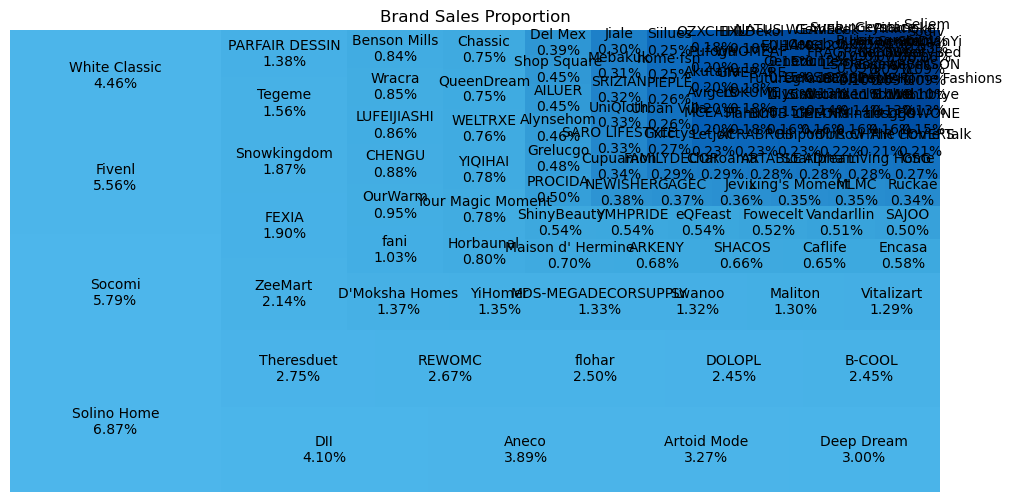

In [8]:
df_brand = df_rawdata.groupby('品牌').agg({
    '近30天销售额($)':'sum',
    '近30天销量':'sum',
    '价格($)':'mean',
    '上架天数':'mean',
    '评分': 'mean',
    '评分数': 'sum',
    '卖家信息': 'count'
})
df_brand['产品数'] = df_brand['卖家信息']
df_brand = df_brand.drop(columns='卖家信息')
df_brand['日销'] = df_brand['近30天销量'].astype('float') / 30
df_brand.insert(0, '日销', df_brand.pop('日销'))
df_brand = df_brand.sort_values(by=['近30天销售额($)'], ascending=False)
df_brand_sum_sales = df_brand['近30天销售额($)'].sum()
df_brand['share'] = ''
for index, row in df_brand.iterrows():
    df_brand.loc[index, 'share'] = row['近30天销售额($)'] / df_brand_sum_sales
df_brand['brand'] = df_brand.index
# round cols
round_cols = ['日销', '近30天销售额($)', '近30天销量', '上架天数', '评分数']
for col in round_cols:
    df_brand[col] = round(df_brand[col].astype('float'))
df_brand['评分'] = round(df_brand['评分'].astype('float'), 1)
df_brand['价格($)'] = round(df_brand['价格($)'].astype('float'), 2)
df_brand['brand_on_share'] = df_brand.apply(lambda row: f"{row['brand']}\n{row['share']:.2%}", axis=1)
print(df_brand.head(3))
top_3_share = df_brand[:3]['share'].sum()
print(f'\r\n前三份额：{round(top_3_share, 2)}')
if top_3_share > 0.75:
    print("存在垄断性")
else:
    print("不存在垄断性")
# # validation
# df_HOMDSG = df_rawdata[df_rawdata['品牌'] == 'BANGSON']
# sales_total_HOMDSG = df_HOMDSG['近30天销量'].sum()
# print(sales_total_HOMDSG)

# 可视化 Visualization
# 计算销售额占比
# 绘制treemap图
plt.figure(figsize=(12,6))
# 自定义蓝色调色板
num_colors = len(df_brand)
blue_palette = mcolors.LinearSegmentedColormap.from_list('BluePalette', ['#4db6eb', '#3ca8de', '#0059b3', '#003380'], N=num_colors)
squarify.plot(sizes=df_brand['share'], label=df_brand['brand_on_share'], alpha=1, color=blue_palette(range(num_colors)))

# 设置图形标题和坐标轴标签
plt.title('Brand Sales Proportion')
plt.axis('off')

# 显示图形
plt.show()
df_brand.to_csv('/kaggle/working/df_brand.csv')


## 4. 特征分析



变量透视图： W


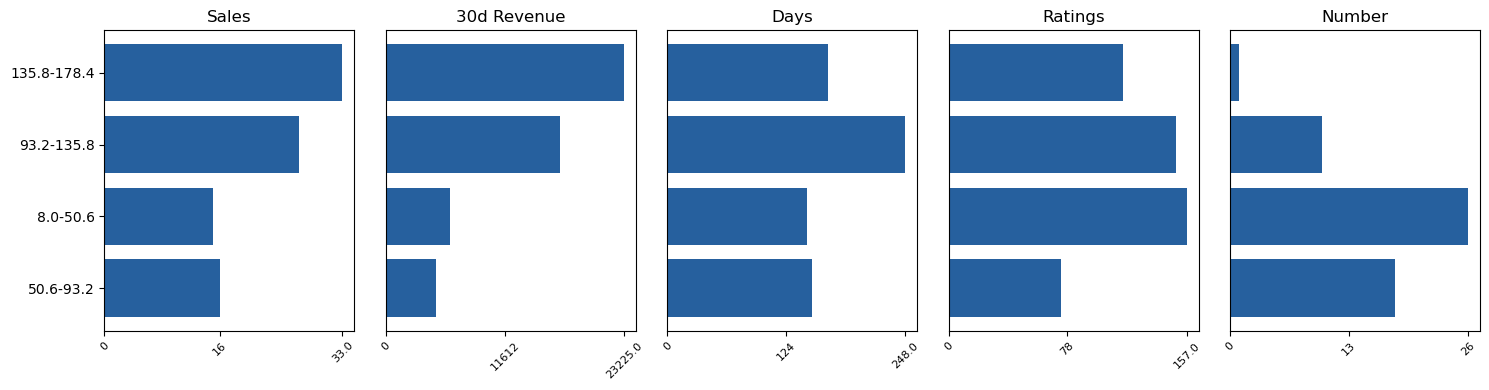

对于特征W, 推荐的特征值为：
Index(['93.2-135.8', '135.8-178.4'], dtype='object', name='W')


变量透视图： D


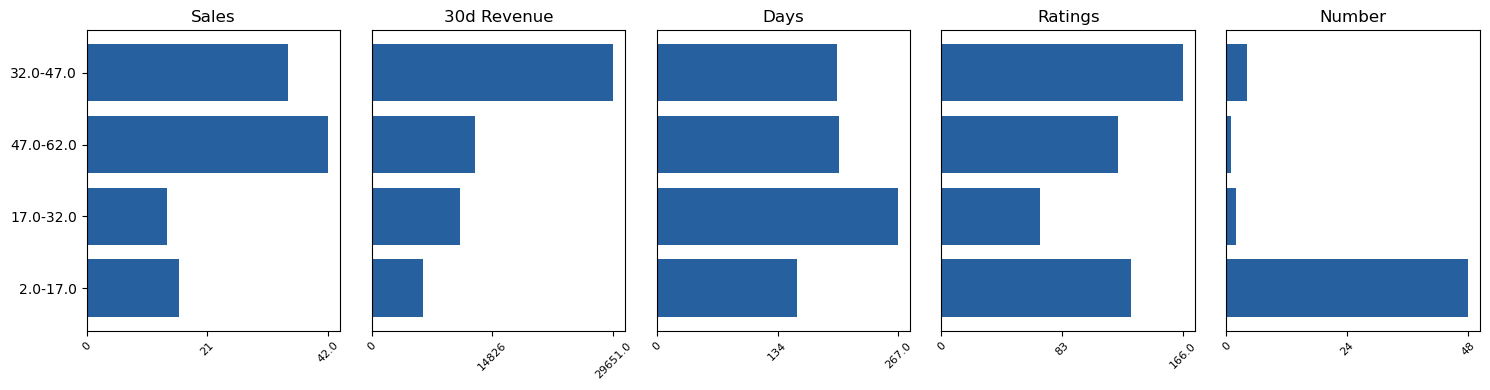

对于特征D, 推荐的特征值为：
Index(['47.0-62.0', '32.0-47.0'], dtype='object', name='D')


变量透视图： MATERIAL


/tmp/ipykernel_20/4123961362.py:99: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/4123961362.py:99: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/4123961362.py:99: UserWarning: Glyph 37231 (\N{CJK UNIFIED IDEOGRAPH-916F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/4123961362.py:99: UserWarning: Glyph 32420 (\N{CJK UNIFIED IDEOGRAPH-7EA4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/4123961362.py:99: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/4123961362.py:99: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/4123961362.py:99: UserWarning: Glyph 20122 (\N{CJK UNIFIED IDEOGRAPH-4E9A}) missing from current font.
  plt.tight_layout()
/tmp/

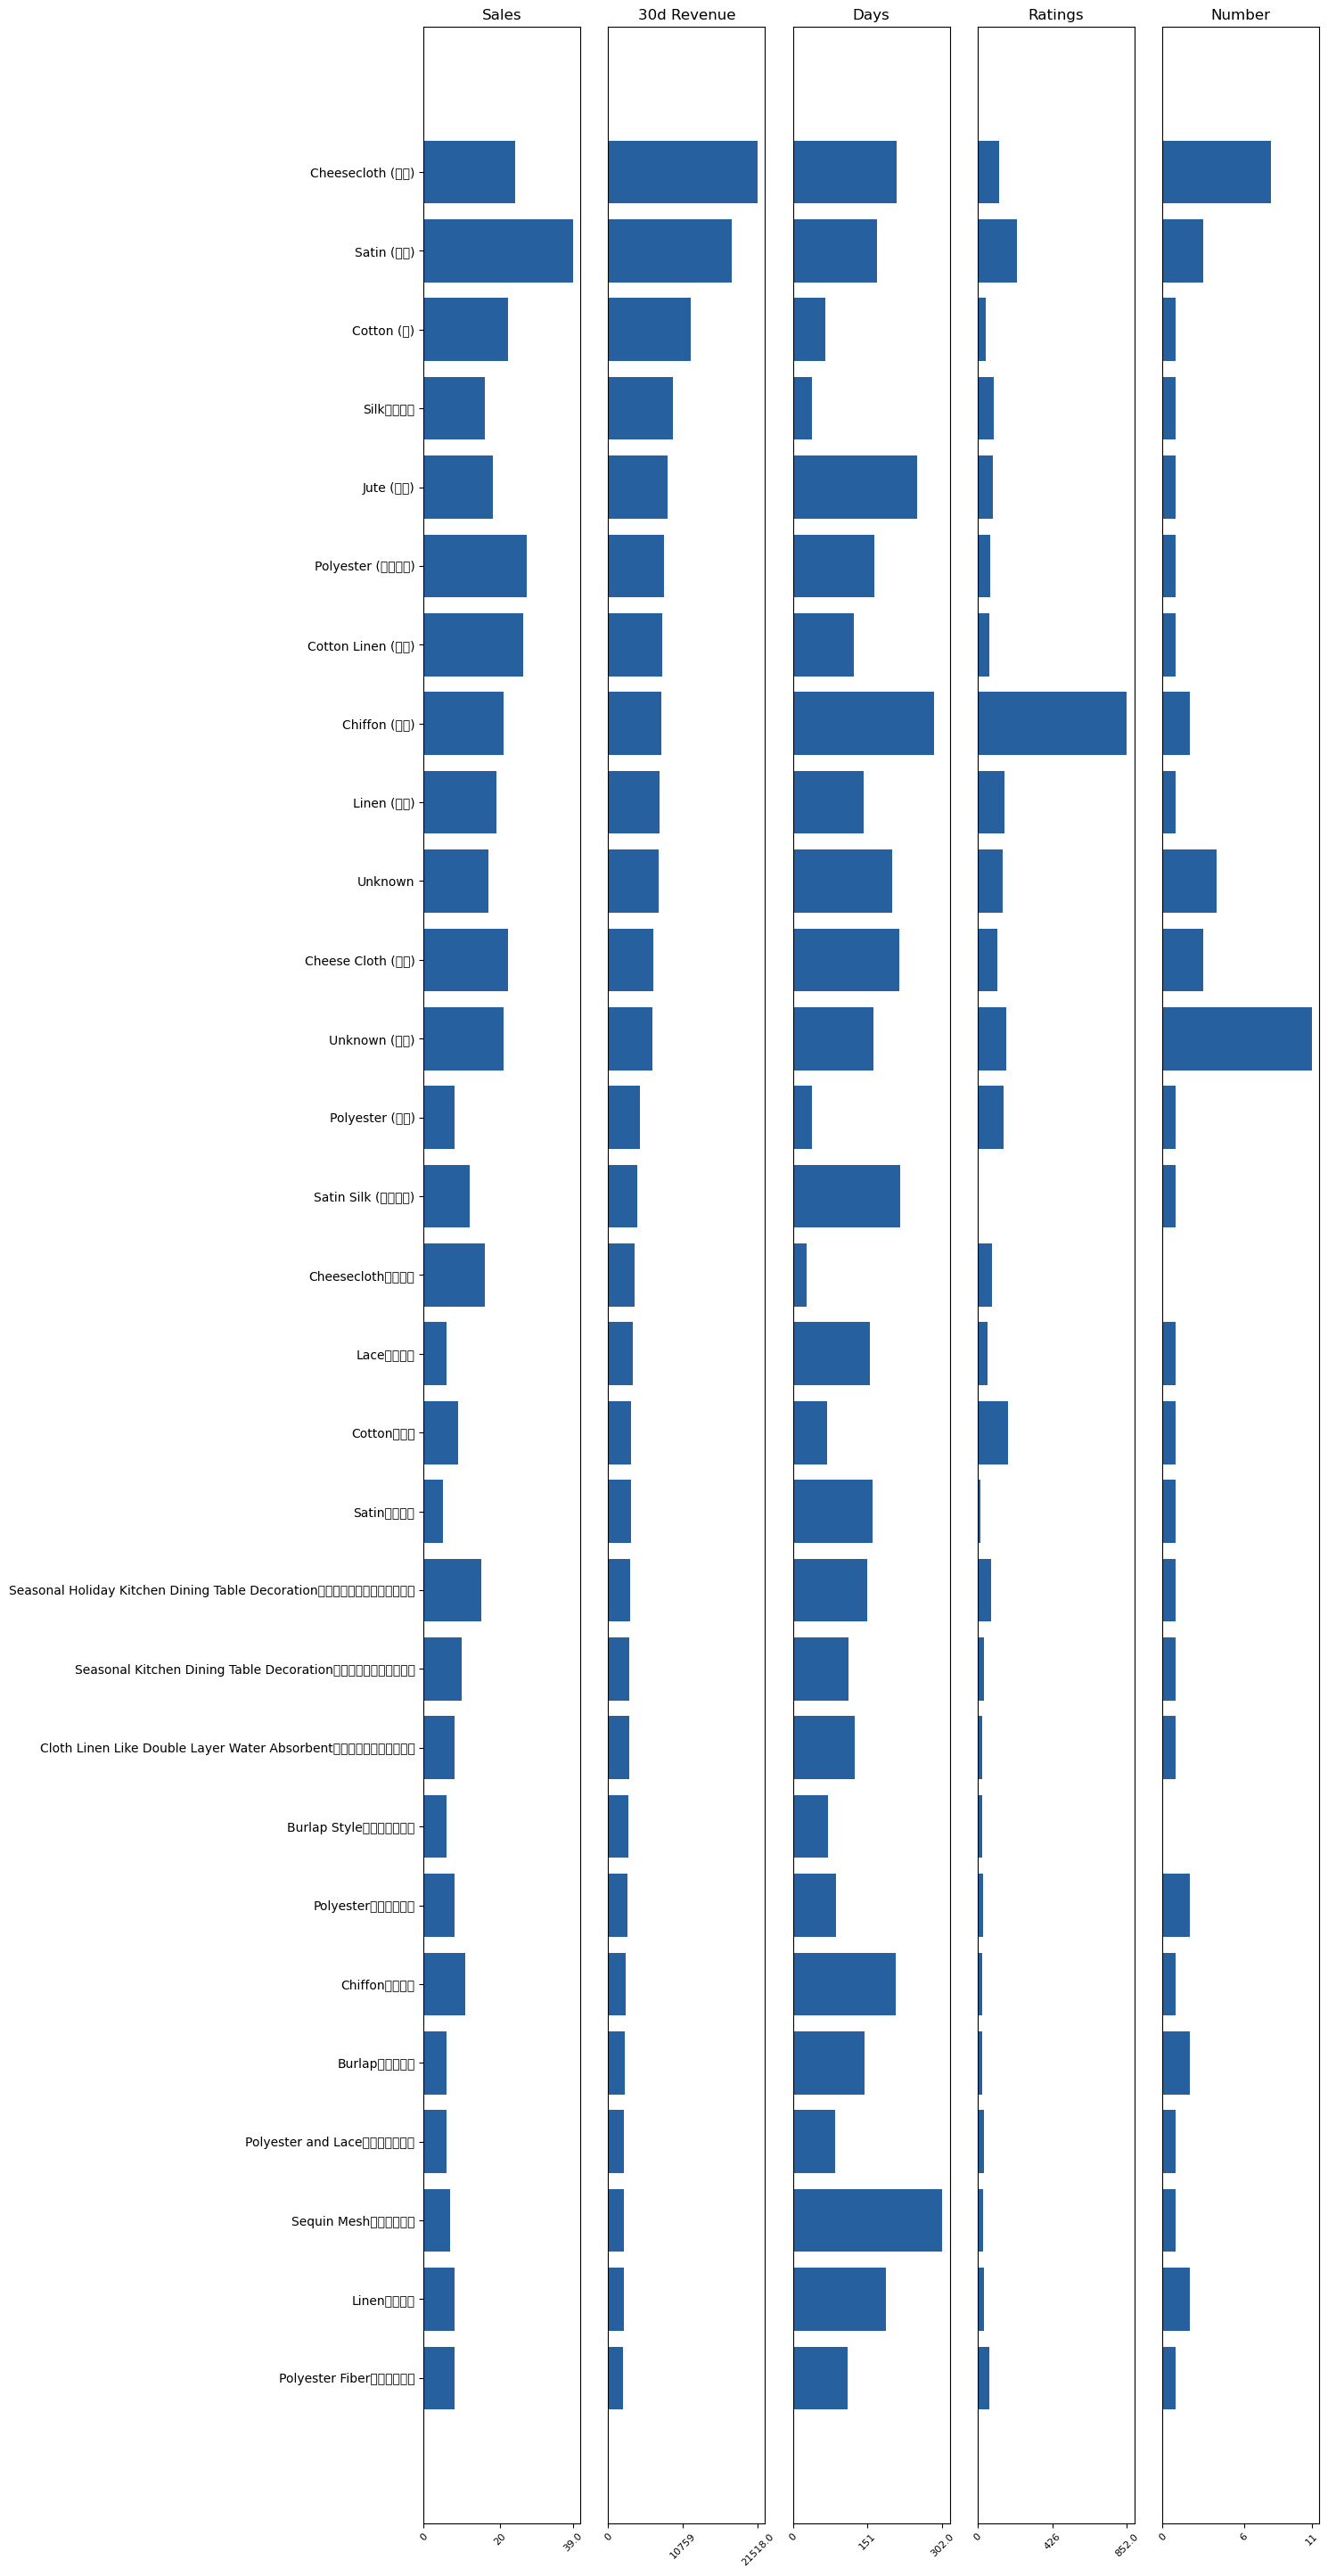

对于特征MATERIAL, 推荐的特征值为：
Index(['Satin (缎子)', 'Cheesecloth (纱布)'], dtype='object', name='MATERIAL')


In [9]:
features= ['COLOR', 'SIZE', 'W', 'D', 'H', 'STYLE', 'ACCESSORIES', 'NUMBER_OF_ITEMS',
              'MATERIAL', 'SHAPE']
def feature_analytics(df_feature, feature):
    has_data = True
    df_feature.index = list(range(len(df_feature)))
    if len(df_feature[feature]) == 0:
#         print(f'[INFO]Skipped, No feature data for {feature}')
        has_data = False
        return None, has_data
    if check_null(df_feature.at[0, feature]):
#         print(f'[INFO]Skipped, No feature data for {feature}')
        has_data = False
        return None, has_data
    df_feature = df_feature.groupby(feature).agg({
        '近30天销售额($)':'mean',
        '近30天销量':'mean',
        '价格($)':'mean',
        '上架天数':'mean',
        '评分': 'mean',
        '评分数': 'mean',
        '卖家信息': 'count'
    })
    df_feature['产品数'] = df_feature['卖家信息']
    df_feature = df_feature.drop(columns='卖家信息')
    df_feature['日销'] = df_feature['近30天销量'].astype('float') / 30
    df_feature.insert(0, '日销', df_feature.pop('日销'))
    df_feature = df_feature.sort_values(by=['近30天销售额($)'], ascending=False)
    df_feature_sum_sales = df_feature['近30天销售额($)'].sum()
    df_feature['share'] = ''
    for index, row in df_feature.iterrows():
        df_feature.loc[index, 'share'] = row['近30天销售额($)'] / df_feature_sum_sales
    df_feature['feature_val'] = df_feature.index
    # round cols
    round_cols = ['日销', '近30天销售额($)', '近30天销量', '上架天数', '评分数']
    for col in round_cols:
        df_feature[col] = round(df_feature[col].astype('float'))
    df_feature['评分'] = round(df_feature['评分'].astype('float'), 1)
    df_feature['价格($)'] = round(df_feature['价格($)'].astype('float'), 2)
    return df_feature, has_data

df_feature = pd.read_csv(特征原始数据路径)
df_feature_1yr = df_feature[df_feature['上架天数'] <= 366]
df_feature_180d = df_feature[df_feature['上架天数'] <= 180]

for feature in features:
    # all
    all_result = feature_analytics(df_feature, feature)
    ft_all = all_result[0]
    ft_all_has = all_result[1]
    # 1yr
    ft_1yr = feature_analytics(df_feature_1yr, feature)[0]
    # 180d
    ft_180d = feature_analytics(df_feature_180d, feature)[0]
    # concat
    if ft_all_has:
        ft_all['区间'] = 'all'
        ft_1yr['区间'] = '1年内'
        ft_180d['区间'] = '180天内'
        vertical_concat = pd.concat([ft_all, ft_1yr, ft_180d], axis=0)
        vertical_concat.to_csv(f'/kaggle/working/df_feature_{feature}.csv')
#         print(vertical_concat.columns)
        mapping = {
            '日销': 'Sales',
            '近30天销售额($)': '30d Revenue',
            '上架天数': 'Days',
            '评分数': 'Ratings',
            '评分': 'Rating',
            '产品数': 'Number',
            'feature_val': 'Feature'
        }
        # 将字段名映射为中文
        vertical_concat.rename(columns=mapping, inplace=True)
        #可视化
        to_visual_data = vertical_concat[vertical_concat['区间'] == '1年内']
        to_visual_data = to_visual_data.sort_values(by=['30d Revenue'], ascending=True)
        
        height = len(to_visual_data)
        
        # 创建图形和子图对象
        fig, axs = plt.subplots(1, 5, figsize=(15, height))
        dimensions = ['Sales', '30d Revenue', 'Days', 'Ratings', 'Number']
        # 绘制子图
        print(f'\r\n')
        print(f'变量透视图： {feature}')
        for index, dimension in enumerate(dimensions):
            xticks = [0, 
                        round(to_visual_data[dimension].max() / 2),
                        to_visual_data[dimension].max()]
            axs[index].barh(to_visual_data['Feature'], to_visual_data[dimension], label=dimension, color='#26609e', alpha=1)
            axs[index].set_title(f'{dimension}')
            axs[index].set_ylabel('', fontsize=6)
            if index > 0:
                axs[index].set_yticks([])
            axs[index].set_xticks(xticks)
            axs[index].set_xticklabels(xticks, rotation=45,fontsize=8)
            

        # 自动调整子图的间距
        plt.tight_layout()

        # 显示图形
        plt.show()
        
        # 推荐特征
        best_two = to_visual_data.tail(2)
        print(f"对于特征{feature}, 推荐的特征值为：")
        print(best_two.index)

## 5. 趋势分析

   datetime  searchvol
0  2018/7/1         37
1  2018/7/8         44


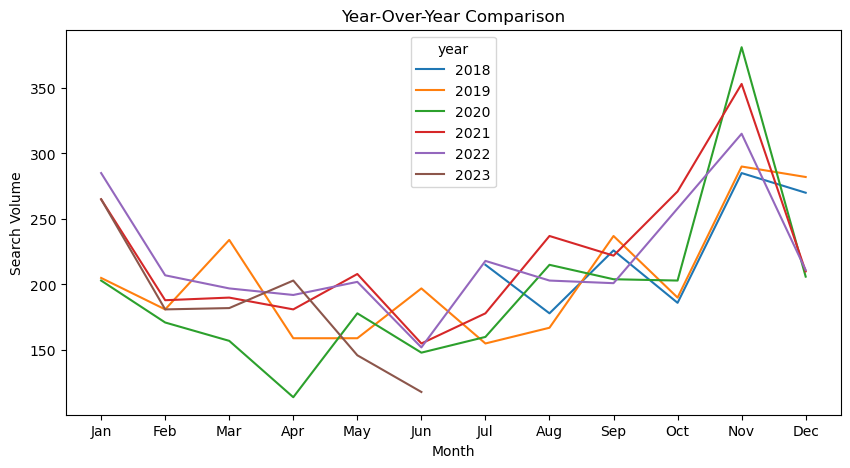

是否存在季节性波动: True
旺季月份: [Timestamp('2018-11-25 00:00:00'), Timestamp('2019-11-24 00:00:00'), Timestamp('2020-11-22 00:00:00'), Timestamp('2021-11-21 00:00:00'), Timestamp('2022-11-20 00:00:00')]
淡季月份: [Timestamp('2019-06-09 00:00:00'), Timestamp('2020-06-07 00:00:00'), Timestamp('2021-06-06 00:00:00'), Timestamp('2022-06-05 00:00:00'), Timestamp('2023-06-04 00:00:00')]


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_trends = pd.read_csv(google数据路径)
print(df_trends.head(2))

# df_trends['datetime'] = pd.to_datetime(df_trends['datetime'], dayfirst=True, format='%d-%m-%y')
df_trends['datetime'] = pd.to_datetime(df_trends['datetime'], format='%Y/%m/%d')
# add a column for year
df_trends['year'] = df_trends['datetime'].dt.year

# group data by year and month, and calculate the search volume
monthly_avg = df_trends.groupby(['year', df_trends['datetime'].dt.month])['searchvol'].sum()

# pivot the data to reshape it into a dataframe 
monthly_avg = monthly_avg.unstack(level=0)

# plot the data as separate lines with different colors
monthly_avg.plot(kind='line', subplots=False, legend=True, figsize=(10,5))

# customize the plot
plt.title(f'Year-Over-Year Comparison')
plt.xlabel('Month')
plt.ylabel('Search Volume')
plt.xticks(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

# 判断季节性
# 如果数据中存在季节性，则不同季节的平均搜索量之间差距较大，而标准差也较大；
# 反之，如果数据每个月份平均搜索量波动比较小，则标准差相对较小。
# 按照时间升序排序
df_trends = df_trends.sort_values('datetime')

# 将日期列转换为日期时间类型
df_trends['datetime'] = pd.to_datetime(df_trends['datetime'])

# 设置日期为索引
df_trends.set_index('datetime', inplace=True)

# 进行季节性分解
result = seasonal_decompose(df_trends['searchvol'], model='additive')

# 获取季节性成分
seasonality = result.seasonal

# 判断是否存在季节性波动
has_seasonality = seasonality.std() > 0

# 确定旺季和淡季的月份
if has_seasonality:
    peak_seasons = seasonality[seasonality == seasonality.max()].index.tolist()
    off_seasons = seasonality[seasonality == seasonality.min()].index.tolist()
else:
    peak_seasons = []
    off_seasons = []

# 输出结果
print("是否存在季节性波动:", has_seasonality)
print("旺季月份:", peak_seasons)
print("淡季月份:", off_seasons)